https://minassaleh.github.io/

## Louisiana Hydrographic Data Analysis for Coastal Erosion Prevention
#### Mina Saleh and Ryan Park

### Project Description

There are a variety of strategies available for combating coastal erosion. One of the best protective elements for our coast is vegetation. In this notebook we will take a look at hydrographic measurements taken across Lousiana's coast in an effort to make a predictive classifier. This classifier will make a recomendation for a particular action to be taken for any given place across the coast. Extensive studies have been made to record hydrographic data in and near the coastal region of Lousiana. With access to data recorded by the Coastal Protection and Restoration Authority (CPRA), we can analyze some fundamental attributes pertaining to vegetative conditions across the coast, namely the water level, the water's temperature, and the quality of the water by looking at the pH and salaninty. This data has been collected across a variety of research sites, with several years of recorded data for each. The data is available [here](https://cims.coastal.louisiana.gov/monitoring-data/).

## Table of Contents

1. [Packages and Requirements](#Packages)
2. [Data Extraction](#Extraction)
3. [Assembly and Tidying](#Tidy)
4. [Load Checkpoint](#Load)
5. [Initial Exploratory Analysis](#Explore)
6. [Statistical Model](#Stat)
7. [Regression Model Prepartion](#Regr)
8. [Results](#Results)

<a name="Packages"></a>
### Packages and Requirements

In this notebook we will be using a variety of packages for our analysis, especially pandas and matplotlib. We will import all our requirements here.

In [1]:
import os
from os import listdir as ls
from os.path import join as pjoin
import re
import requests
import time

import geopandas as gpd
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Point, Polygon
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

<a name="Extraction"></a>
### Data Extraction

The CPRA offers weekly updated extracts for several different sets of actively monitored features. We will be interested in the following data sets from [this link](https://cims.coastal.louisiana.gov/FullTableExports.aspx).

Under ```Full Table Exports - All Available Data```:
1. Discrete Hydrographic (Monthly)
2. Soil Properties
3. Accretion
4. Aboveground Biomass

<a name="Tidy"></a>
### Data Loading and Tidying

After downloading and unzipping, we are left with csv files. We shall install these into a data folder such that the directory structure relative to the location of this notebook includes these files like so:
```
./data/
    |——Full_Discrete_Hydrographic.csv
    |——Full_Soil_Properties.csv
    |——Full_Accretion.csv
    |——Full_Biomass.csv
```
in preparation for the load step below. Let's have a look.

In [6]:
# Load the data into pandas dataframes.
hydro_untidy = pd.read_csv(pjoin("data", "Full_Discrete_Hydrographic.csv"), encoding="latin1")
accretion_untidy = pd.read_csv(pjoin("data", "Full_Accretion.csv"), encoding="latin1")
biomass_untidy = pd.read_csv(pjoin("data", "Full_Biomass.csv"), encoding="latin1")
soil_untidy = pd.read_csv(pjoin("data", "Full_Soil_Properties.csv"), encoding="latin1")
# Take a look at the data
display(hydro_untidy.head(2))
display(accretion_untidy.head(2))
display(biomass_untidy.head(2))
display(soil_untidy.head(2))

/Users/ryan/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning: Columns (1,19,20,21,22,23,24,26,28,29,31,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CPRA Station ID,Original Collector Station ID,Date (mm/dd/yyyy),Time (hh:mm),Time Zone,Staff Gauge (ft),Geoid,Station Depth (ft),Measurement Depth (ft),Water Temperature (°C),...,Silica (unfiltered; mg/L),Silica (filtered; mg/L),Total Suspended Solids (mg/L),Volatile Suspended Solids (mg/L),Secchi (ft),Fecal Coliform (MPN/100ml),Organization Name,Comments,Latitude,Longitude
0,BA-WQ-TS1-01,NaN,7/25/2018,12:25,CST,NaN,NaN,22.96,1.64,29.5,...,2.10,NaN,19.0,NaN,NaN,NaN,LA DEPT OF ENV QUAL,Coastal Transect Study; samples analyzed by PA...,29.274,-89.9545
1,BA-WQ-TS1-01,NaN,9/26/2018,09:53,CST,NaN,NaN,16.40,3.28,29.4,...,2.60,NaN,27.0,NaN,NaN,NaN,LA DEPT OF ENV QUAL,Coastal Transect Study; samples analyzed by PA...,29.274,-89.9545


,Station ID,Group,Sample Date (mm/dd/yyyy),Sample Time (hh:mm),Establishment Date (mm/dd/yyyy),Establishment Time (hh:mm),Time Zone,Core X:Y,Accretion Measurement 1 (mm),Accretion Measurement 2 (mm),Accretion Measurement 3 (mm),Accretion Measurement 4 (mm),Core Conditions,Organization,Personnel,Notes,Latitude,Longitude
0,BA39-01A01,PS2,9/21/2010,12:50,9/21/2010,12:50,CST,0;0,0.0,0.0,0.0,0.0,Feldspar Established (n=4),COASTAL PROTECTION AND RESTORATION AUTHORITY,B. Gossman;,"These data were inserted by CPRA in July, 2020...",29.65117,-90.020267
1,BA39-01A01,PS2,4/11/2011,12:00,9/21/2010,12:50,CST,1;2,0.0,3.0,2.0,NaN,Good (Solid Feldspar; n=3); half of a core at ...,COASTAL ESTUARY SERVICES LLC,K. Peterson; K. Busurelo; G. Pittman,Feldspar visible on surface; Site is not flood...,29.65117,-90.020267


,Station ID,Sample Date (mm/dd/yyyy),Plot Size (m2),Total Plot Aboveground Live Biomass (g/m2),Total Plot Aboveground Dead Biomass (g/m2),Scientific Name As Originally Observed,Common Name As Originally Observed,Scientific Name as Currently Recognized,Common Name as Currently Recognized,Live stems (N),...,Standard Error Live Stem Diameter (mm),Aboveground Live Biomass (g/m2),Total Carbon (mg/g),Total Nitrogen (mg/g),Total Phosphorus (mg/kg),Organization,Personnel,Comments,Latitude,Longitude
0,CRMS0003-BAG01,9/15/2017,0.25,361.68,88.92,Spartina alterniflora Loisel.,smooth cordgrass,Spartina alterniflora Loisel.,smooth cordgrass,155.0,...,0.3,361.68,430.68,8.64,899.0,U.S. GEOL SURVEY (USGS),"Hamm, K",NaN,30.099428,-89.252902
1,CRMS0003-BAG02,9/15/2017,0.25,448.72,59.44,Spartina alterniflora Loisel.,smooth cordgrass,Spartina alterniflora Loisel.,smooth cordgrass,208.0,...,0.2,448.72,423.47,8.34,790.0,U.S. GEOL SURVEY (USGS),"Hamm, K",NaN,30.099302,-89.252896


,Station ID,Group,Sample Date (mm/dd/yyyy),Sample Depth (cm),Wet Soil pH (pH units),Dry Soil pH (pH units),Soil Specific Conductance (uS/cm),Soil Salinity (ppt),Soil Moisture Content (%),Bulk Density (g/cm3),...,Particle Size Mean (phi),Particle Size Median (phi),Particle Size Standard Deviation (phi),Radiometric Dating Method and Units,Isotope Concentration,Organization,Personnel,Comments,Latitude,Longitude
0,BA02-100,NaN,11/4/2008,0 to 16,6.85,6.16,2477.0,1.25,76.00,0.30,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,E. Bourg; P. Ritchie,NaN,29.533662,-90.22699
1,BA02-100-CS,NaN,9/12/2012,0 to 16,6.10,5.79,2317.0,1.15,69.29,0.33,...,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,H. Bernard; T. Nguyen; M. Mohler,NaN,29.533662,-90.22699


#### Tidying Hydrographic Data

Some data like the comments, time zone, org name, and station ID aren't necessary for the present analysis, so we will leave them out. We would also like to convert all of the time data into datetime objects for easy time manipulation later.

In [7]:
# We can observe the columns
print(hydro_untidy.columns)
# Focus on only the columns we care about
col_drops = ["Velocity (ft/sec)", "Time Zone", "Comments",
             "Organization Name", "Original Collector Station ID"]
hydro_subset = hydro_untidy.drop(col_drops, axis=1)
# Rename some columns to simplify or match other dset columns
hydro_subset = hydro_subset.rename(
    columns={"CPRA Station ID": "Station ID",
             "pH (pH units)": "pH"})
# Check timezone
# print(hydro["Time Zone"].unique()) # all CST

# Create pandas datetime columns
def convert_dt(df, prefix=""):
    """Takes in a DataFrame with Date and Time columns and replaces them with a Datetime column"""
    df.loc[:, "Datetime"] = pd.to_datetime(
        df[f"{prefix}Date (mm/dd/yyyy)"] + "_" + df[f"{prefix}Time (hh:mm)"],
        format="%m/%d/%Y_%H:%M")
    return df.drop([f"{prefix}Time (hh:mm)", f"{prefix}Date (mm/dd/yyyy)"], axis=1)

hydro = convert_dt(hydro_subset)
hydro.head()

Index(['CPRA Station ID', 'Original Collector Station ID', 'Date (mm/dd/yyyy)',
       'Time (hh:mm)', 'Time Zone', 'Staff Gauge (ft)', 'Geoid',
       'Station Depth (ft)', 'Measurement Depth (ft)',
       'Water Temperature (°C)', 'Specific Conductance (uS/cm)',
       'Salinity (ppt)', 'Dissolved Oxygen (mg/L)', 'pH (pH units)',
       'Velocity (ft/sec)', 'Soil Porewater Temperature (°C)',
       'Soil Porewater Specific Conductance (uS/cm)',
       'Soil Porewater Salinity (ppt)', 'Turbidity (FNU)',
       'Chlorophyll a (ug/L)', 'Total Nitrogen (mg/L)',
       'Total Kjeldahl Nitrogen (mg/L)', 'Nitrate as N (mg/L)',
       'Nitrite as N (mg/L)', 'Nitrate+Nitrite as N (unfiltered; mg/L)',
       'Nitrate+Nitrite as N (filtered; mg/L)',
       'Ammonium as N (unfiltered; mg/L)', 'Ammonium as N (filtered; mg/L)',
       'Total Phosphorus (mg/L)', 'Orthophosphate as P (unfiltered; mg/L)',
       'Orthophosphate as P (filtered; mg/L)', 'Silica (unfiltered; mg/L)',
       'Silica (filt

,Station ID,Staff Gauge (ft),Geoid,Station Depth (ft),Measurement Depth (ft),Water Temperature (°C),Specific Conductance (uS/cm),Salinity (ppt),Dissolved Oxygen (mg/L),pH,...,Orthophosphate as P (filtered; mg/L),Silica (unfiltered; mg/L),Silica (filtered; mg/L),Total Suspended Solids (mg/L),Volatile Suspended Solids (mg/L),Secchi (ft),Fecal Coliform (MPN/100ml),Latitude,Longitude,Datetime
0,BA-WQ-TS1-01,NaN,NaN,22.96,1.64,29.5,40211.7,25.6,8.8,8.3,...,NaN,2.10,NaN,19.0,NaN,NaN,NaN,29.274,-89.9545,2018-07-25 12:25:00
1,BA-WQ-TS1-01,NaN,NaN,16.40,3.28,29.4,26066.0,15.9,5.9,8.5,...,NaN,2.60,NaN,27.0,NaN,NaN,NaN,29.274,-89.9545,2018-09-26 09:53:00
2,BA-WQ-TS1-01,NaN,NaN,19.68,1.64,19.1,16827.5,9.9,10.1,8.5,...,0.02,NaN,1.24,15.04,NaN,NaN,NaN,29.274,-89.9545,2019-03-26 12:00:00
3,BA-WQ-TS1-01,NaN,NaN,19.68,3.28,27.6,26890.4,11.8,7.5,8.5,...,0.05,NaN,0.91,49.34,NaN,NaN,NaN,29.274,-89.9545,2019-05-21 11:48:00
4,BA-WQ-TS1-01,NaN,NaN,26.24,3.28,28.7,24060.1,14.6,8.9,9.3,...,0.04,NaN,1.58,10.59,NaN,NaN,NaN,29.274,-89.9545,2019-07-25 12:32:00


#### Tidying Accretion Data
We can select the main accretion data of interest and average together the samples on the feldspare core. This will provide the estimate of soil accretion since establishment for the local station at each site. One issue with this dataset is that although the feature title indicates dates reported in (mm/dd/yyyy) format, some of the dates are in fact reported as (mm/dd/yy), so we must fix that before created datetime objects.

In [4]:
# Observe the dataset columns
print(accretion_untidy.columns)
# Focus on only the columns we care about
col_drops = ["Core Conditions", "Core X:Y", "Time Zone",
             "Organization", "Personnel", "Notes",
             "Group"]
acc_subset = accretion_untidy.drop(col_drops, axis=1)
# Inspect date formats.
# print(accretion_untidy["Sample Date (mm/dd/yyyy)"].value_counts())
# It appears that there are several dates given in a different format
def reformat_date(d):
    """Convert mm/dd/yy to mm/dd/yyyy"""
    sps = d.split("/")
    if len(sps[-1]) == 2:
        return "/".join(sps[:-1] + ["20"+sps[-1]])
    return d
# Reformat them here.
dcols = ["Sample Date (mm/dd/yyyy)", "Establishment Date (mm/dd/yyyy)"]
acc_subset[dcols[0]] = acc_subset[dcols[0]].map(reformat_date)
acc_subset[dcols[1]] = acc_subset[dcols[1]].map(reformat_date)

# Create an average accretion Measurement
acc_subset.loc[:, "Accretion (mm)"] = acc_subset[
    [f"Accretion Measurement {i} (mm)" for i in range(1,5)]].apply(np.mean, axis=1)
# Create datetime columns
accretion_ = convert_dt(acc_subset, prefix="Sample ")
accretion = convert_dt(accretion_, prefix="Establishment ")
accretion.head()

Index(['Station ID', 'Group', 'Sample Date (mm/dd/yyyy)',
       'Sample Time (hh:mm)', 'Establishment Date (mm/dd/yyyy)',
       'Establishment Time (hh:mm)', 'Time Zone', 'Core X:Y',
       'Accretion Measurement 1 (mm)', 'Accretion Measurement 2 (mm)',
       'Accretion Measurement 3 (mm)', 'Accretion Measurement 4 (mm)',
       'Core Conditions', 'Organization', 'Personnel', 'Notes', 'Latitude',
       'Longitude'],
      dtype='object')


,Station ID,Accretion Measurement 1 (mm),Accretion Measurement 2 (mm),Accretion Measurement 3 (mm),Accretion Measurement 4 (mm),Latitude,Longitude,Accretion (mm),Datetime
0,BA39-01A01,0.0,0.0,0.0,0.0,29.65117,-90.020267,0.000000,2010-09-21 12:50:00
1,BA39-01A01,0.0,3.0,2.0,NaN,29.65117,-90.020267,1.666667,2010-09-21 12:50:00
2,BA39-01A01,NaN,NaN,NaN,NaN,29.65117,-90.020267,NaN,2010-09-21 12:50:00
3,BA39-01A01,0.0,0.0,0.0,NaN,29.65117,-90.020267,0.000000,2010-09-21 12:50:00
4,BA39-01A01,8.0,10.0,14.0,12.0,29.65117,-90.020267,11.000000,2010-09-21 12:50:00


#### Tidying Biomass Data

Here we are interested in the density of vegetation in certain regions over time. We don't care as much about the scientific naming of plants or the height of the plants at the moment.

In [5]:
# Observe the dataset columns
print(biomass_untidy.columns)
# Focus on only the columns we care about
col_drops = ["Plot Size (m2)", "Scientific Name As Originally Observed",
             "Common Name As Originally Observed",
             "Standard Error Live Stem Diameter (mm)",
             "Standard Error Live Stem Height (cm)",
             "Scientific Name as Currently Recognized", "Comments", "Organization",
             "Personnel", "Live stems (N)"]
bio_subset = biomass_untidy.drop(col_drops, axis=1)
# Create datetime columns
bio_subset.loc[:, "Datetime"] = pd.to_datetime(bio_subset["Sample Date (mm/dd/yyyy)"], format="%m/%d/%Y")
biomass = bio_subset.drop("Sample Date (mm/dd/yyyy)", axis=1)
biomass.head()

Index(['Station ID', 'Sample Date (mm/dd/yyyy)', 'Plot Size (m2)',
       'Total Plot Aboveground Live Biomass (g/m2)',
       'Total Plot Aboveground Dead Biomass (g/m2)',
       'Scientific Name As Originally Observed',
       'Common Name As Originally Observed',
       'Scientific Name as Currently Recognized',
       'Common Name as Currently Recognized', 'Live stems (N)',
       'Average Live Stem Height (cm)', 'Standard Error Live Stem Height (cm)',
       'Average Live Stem Diameter (mm)',
       'Standard Error Live Stem Diameter (mm)',
       'Aboveground Live Biomass (g/m2)', 'Total Carbon (mg/g)',
       'Total Nitrogen (mg/g)', 'Total Phosphorus (mg/kg)', 'Organization',
       'Personnel', 'Comments', 'Latitude', 'Longitude'],
      dtype='object')


,Station ID,Total Plot Aboveground Live Biomass (g/m2),Total Plot Aboveground Dead Biomass (g/m2),Common Name as Currently Recognized,Average Live Stem Height (cm),Average Live Stem Diameter (mm),Aboveground Live Biomass (g/m2),Total Carbon (mg/g),Total Nitrogen (mg/g),Total Phosphorus (mg/kg),Latitude,Longitude,Datetime
0,CRMS0003-BAG01,361.68,88.92,smooth cordgrass,36.0,4.6,361.68,430.68,8.64,899.0,30.099428,-89.252902,2017-09-15
1,CRMS0003-BAG02,448.72,59.44,smooth cordgrass,37.2,3.8,448.72,423.47,8.34,790.0,30.099302,-89.252896,2017-09-15
2,CRMS0003-BAG03,533.32,15.12,smooth cordgrass,48.6,5.2,533.32,425.97,6.86,717.0,30.099279,-89.252731,2017-09-15
3,CRMS0030-BAG01,905.76,703.04,saltmeadow cordgrass,156.7,3.8,374.60,452.35,10.05,840.0,30.303690,-90.325453,2017-08-15
4,CRMS0030-BAG01,905.76,703.04,bulltongue arrowhead,137.7,26.8,435.64,441.58,28.76,2213.0,30.303690,-90.325453,2017-08-15


#### Tidying Soil Data

In [6]:
# Observe the dataset columns
print(soil_untidy.columns)
# # Focus on only the columns we care about
col_drops = ["Group", "Organization", "Personnel", "Comments"]
soil_subset = soil_untidy.drop(col_drops, axis=1)
# Rename some columns
soil_subset = soil_subset.rename(
    columns={"Wet Soil pH (pH units)": "Soil pH"})
# Create datetime columns
soil_subset.loc[:, "Datetime"] = pd.to_datetime(soil_subset["Sample Date (mm/dd/yyyy)"], format="%m/%d/%Y")
soil = soil_subset.drop("Sample Date (mm/dd/yyyy)", axis=1)
soil.head()

Index(['Station ID', 'Group', 'Sample Date (mm/dd/yyyy)', 'Sample Depth (cm)',
       'Wet Soil pH (pH units)', 'Dry Soil pH (pH units)',
       'Soil Specific Conductance (uS/cm)', 'Soil Salinity (ppt)',
       'Soil Moisture Content (%)', 'Bulk Density (g/cm3)',
       'Organic Matter (%)', 'Wet Volume (cm3)', 'Dry Volume (cm3)',
       'Biomass Target Flora Species', 'Belowground Live Biomass (g/m2)',
       'Belowground Dead Biomass (g/m2)', 'Organic Density (g/cm3)',
       'Total Carbon (g/kg)', 'Carbon Density (mg/cm3)',
       'Total Nitrogen (g/kg)', 'Total Phosphorus (mg/kg)', 'Sand (%)',
       'Silt (%)', 'Clay (%)', 'Particle Size Mean (phi)',
       'Particle Size Median (phi)', 'Particle Size Standard Deviation (phi)',
       'Radiometric Dating Method and Units', 'Isotope Concentration',
       'Organization', 'Personnel', 'Comments', 'Latitude', 'Longitude'],
      dtype='object')


,Station ID,Sample Depth (cm),Soil pH,Dry Soil pH (pH units),Soil Specific Conductance (uS/cm),Soil Salinity (ppt),Soil Moisture Content (%),Bulk Density (g/cm3),Organic Matter (%),Wet Volume (cm3),...,Silt (%),Clay (%),Particle Size Mean (phi),Particle Size Median (phi),Particle Size Standard Deviation (phi),Radiometric Dating Method and Units,Isotope Concentration,Latitude,Longitude,Datetime
0,BA02-100,0 to 16,6.85,6.16,2477.0,1.25,76.00,0.30,15.47,1297.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.533662,-90.22699,2008-11-04
1,BA02-100-CS,0 to 16,6.10,5.79,2317.0,1.15,69.29,0.33,22.47,1297.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.533662,-90.22699,2012-09-12
2,BA02-100-CS,0 to 16,NaN,NaN,NaN,NaN,75.07,0.37,26.41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.533662,-90.22699,2016-10-17
3,BA02-100-GS,0 to 4,6.38,5.85,1726.0,0.90,68.71,0.25,20.08,324.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.533662,-90.22699,2012-09-12
4,BA02-100-GS,0 to 4,NaN,NaN,NaN,NaN,88.47,0.31,52.73,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.533662,-90.22699,2016-10-17


<a name="Explore"></a>
### Exploratory Data Analysis

Now that we have the data we need, let's start investigating the structure and location of this data, starting out by plotting the data on a Lousisana state map using geopandas and the lattitude and longitude features of each set.

#### Site Locations
We will start by mapping out all of the sites on a map of Louisiana. We would like to see where all the unique sites are for each data set that we have assembled

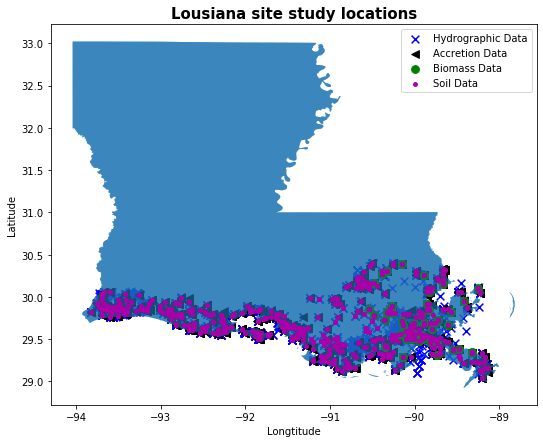

In [7]:
states = gpd.read_file("cb_2017_us_state_500k")
def LA_plot(df, ax, title="", nodat=False, **plot_kw):
    """Scatter plot laid upon Louisiana using geopandas."""
    geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
    geo_df = gpd.GeoDataFrame(df, geometry=geometry)
    # Set graph features
    ax.set_xlabel("Longtitude")
    ax.set_ylabel("Latitude")
    states[states['NAME'] == 'Louisiana'].plot(ax=ax, alpha=0.4)
    if not nodat:
        geo_df.plot(ax=ax, **plot_kw)

# Create figure for LA
fig, ax = plt.subplots(figsize=(11,7))
# Plot location of sites from three datasets
for df, label, c, shape in zip([hydro, accretion, biomass, soil],
                        [f"{i} Data" for i in ["Hydrographic", "Accretion", "Biomass", "Soil"]],
                        ["blue", "black", "green", "#AA00AA"],
                        ["x", "<", "o", "."]):
    LA_plot(df.groupby("Station ID").first(), ax, alpha=1, label=label, legend=True,
            markersize=60, c=c, marker=shape)

# Axes options
ax.set_title("Lousiana site study locations", fontsize=15, fontweight="bold");
ax.legend();

#### Hydrographic Variance
Since our project plans to recommend the best possible erosion protection strategy per water research site, we will start by looking at how varied the sites we are looking at actually are. 

We will first take a look at the staff gauge. Staff gauges signify how deep the water level at a particular site are. Having staff gauge data can be useful for identifying the water level development at a particular site. Additionally, as used below, examining the stagg gauge records can be useful for developing a preliminary idea on the uniformity of protection measures. 

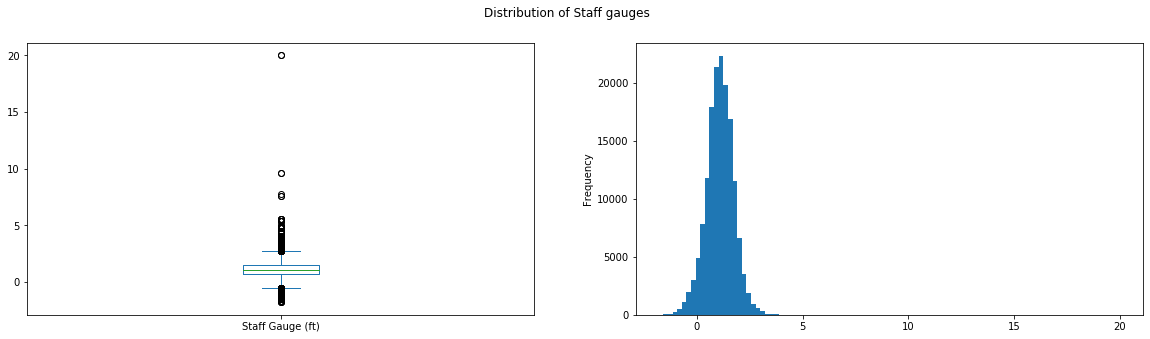

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
hydro["Staff Gauge (ft)"].plot.box(ax = ax[0])
hydro["Staff Gauge (ft)"].plot.hist(bins = 100);
fig.suptitle("Distribution of Staff gauges");

Let's apply a similar sort of analysis to each of the pH and salinity. The water's pH will not necassarily make a difference in how suceptible an area is to flooding, or erosion, but can impact the choice of protection strategy. 

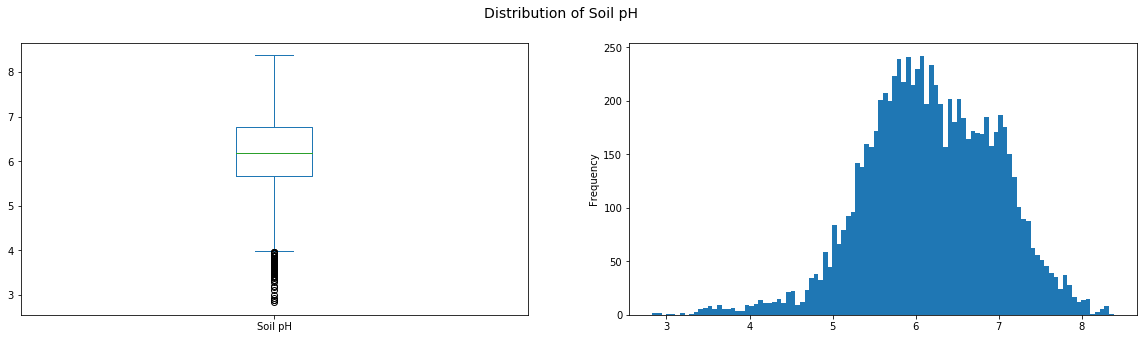

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
soil["Soil pH"].plot.box(ax = ax[0])
soil["Soil pH"].plot.hist(bins = 100);
fig.suptitle("Distribution of Soil pH", fontsize=14);

Here's another very similat test for salinity. We expect this may be another factor in the ability of a region to host vegetative growth after a long period of time.

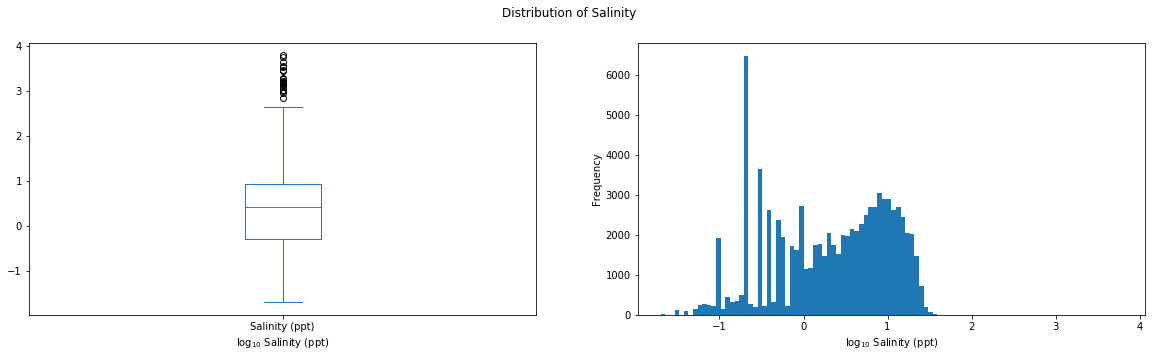

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
hydro[hydro["Salinity (ppt)"] > 0]["Salinity (ppt)"].map(np.log10).plot.box(ax = ax[0])
hydro[hydro["Salinity (ppt)"] > 0]["Salinity (ppt)"].map(np.log10).plot.hist(bins = 100)
ax[1].set_xlabel("log$_{10}$ Salinity (ppt)");
ax[0].set_xlabel("log$_{10}$ Salinity (ppt)");
fig.suptitle(r"Distribution of Salinity");

hydro["log Salinity (ppt)"] = hydro["Salinity (ppt)"].map(lambda x: -10 if x <= 0 else np.log10(x))

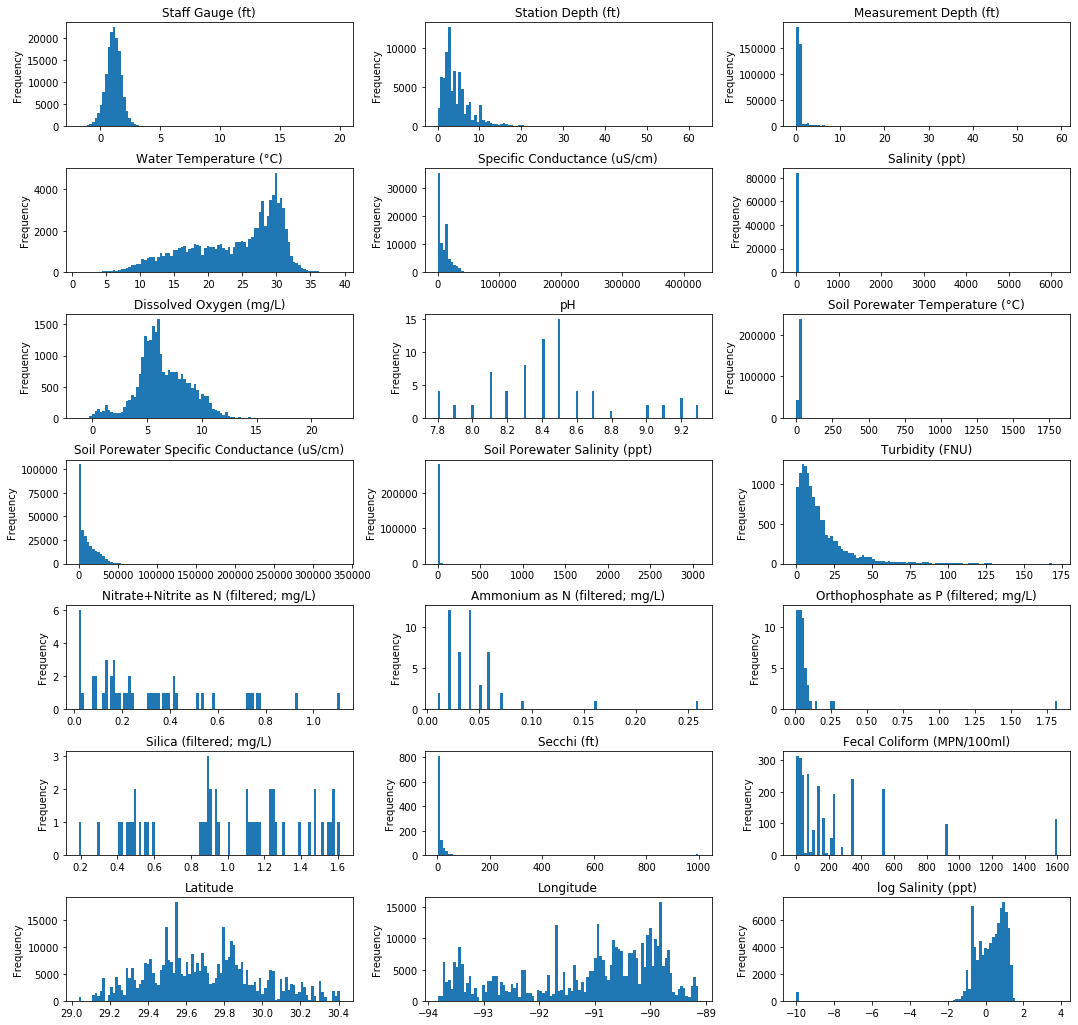

In [11]:
# Let's finally look at all the hydrographic variables together.
figdims = int(np.ceil(len(hydro.columns)**0.5))
numerical = hydro.select_dtypes(include=np.number)
fig, axs = plt.subplots(7, 3, figsize=(18, 18))
axs = axs.flatten()
for i, (v, s) in enumerate(numerical.iteritems()):
    hydro[v].plot.hist(ax=axs[i], bins = 100);
    axs[i].set_title(v)
fig.subplots_adjust(hspace=0.40, wspace=0.25)

Here we observe the log transform of the data, lest we are unable to see the finer detail of all the data between 1e-3 and 1e4 ppt. In fact, we will compute a transformed version of this variable for later use.

#### Vegetation Conditions and Interpolation

One of the most cost effective ways to mitigate the threat of erosion is through the effective use of vegetation. That's right, gardening can be as much a pastime as it could be a salvation effort for the cause. 

Plant roots can sturdy the structure of the sand, and reduce the risk of erosion. Plants typically thrive at PH between a PH of 5 and 7. None of our sites have that, but fortunately some varieties can grow at PH's as high as 8.5, which qualifies a good number of the sites, albeit tenuously. Let's take a look. 

In [12]:
unique_stations=(pd.unique(soil["Station ID"]))
pH_eligible=soil[(soil["Soil pH"] < 8.6) & (soil["Soil pH"] > 5)]
display(pH_eligible)
stations=pd.unique(soil["Station ID"])
pH_stations=pd.unique(pH_eligible["Station ID"])
print(len(pH_stations)/len(stations))

,Station ID,Sample Depth (cm),Soil pH,Dry Soil pH (pH units),Soil Specific Conductance (uS/cm),Soil Salinity (ppt),Soil Moisture Content (%),Bulk Density (g/cm3),Organic Matter (%),Wet Volume (cm3),...,Silt (%),Clay (%),Particle Size Mean (phi),Particle Size Median (phi),Particle Size Standard Deviation (phi),Radiometric Dating Method and Units,Isotope Concentration,Latitude,Longitude,Datetime
0,BA02-100,0 to 16,6.85,6.16,2477.0,1.25,76.00,0.30,15.47,1297.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.533662,-90.226990,2008-11-04
1,BA02-100-CS,0 to 16,6.10,5.79,2317.0,1.15,69.29,0.33,22.47,1297.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.533662,-90.226990,2012-09-12
3,BA02-100-GS,0 to 4,6.38,5.85,1726.0,0.90,68.71,0.25,20.08,324.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.533662,-90.226990,2012-09-12
5,BA02-101,0 to 16,6.51,5.56,2512.0,1.30,89.98,0.11,42.77,1297.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.513034,-90.244852,2008-11-04
6,BA02-101-CS,0 to 16,5.83,5.64,1923.0,0.95,84.04,0.11,61.67,1297.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.513034,-90.244852,2012-09-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14470,TV21NA4-S03,4 to 8,7.33,7.11,3686.0,2.00,58.80,0.58,11.03,324.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.564844,-91.714988,2012-02-07
14471,TV21NA4-S03,8 to 12,7.30,7.25,4614.0,2.50,62.87,0.46,12.19,324.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.564844,-91.714988,2012-02-07
14472,TV21NA4-S03,12 to 16,7.45,7.10,5560.0,3.00,66.55,0.40,15.81,324.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.564844,-91.714988,2012-02-07
14473,TV21NA4-S03,16 to 20,7.43,6.70,5695.0,3.10,67.15,0.43,17.79,324.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.564844,-91.714988,2012-02-07


0.5445218028581899


About 53% of the stations were eligible. This is a positive sign. 

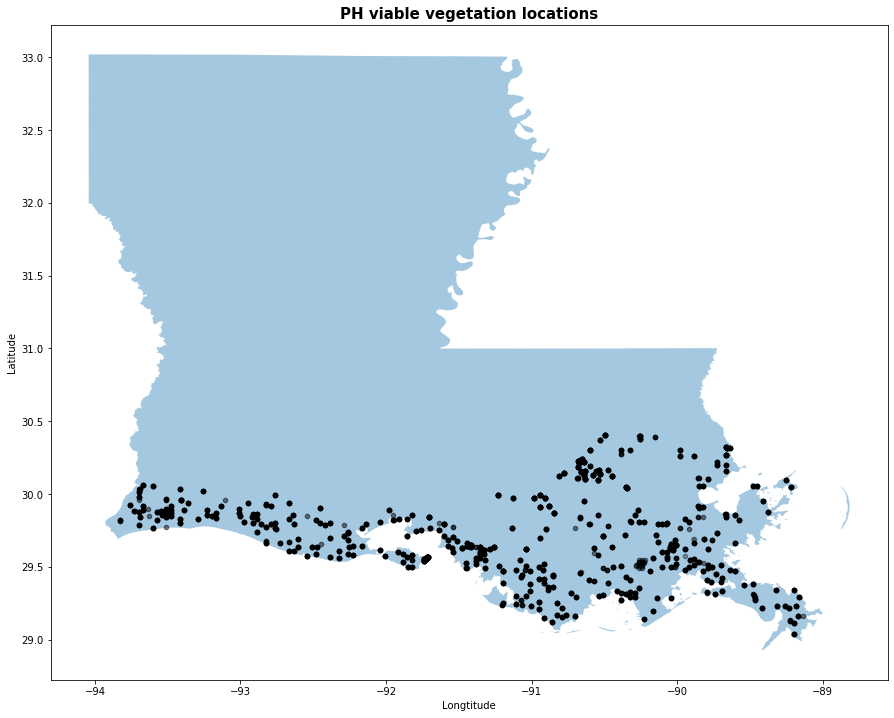

In [13]:
# Create axes for map object.
fig, ax = plt.subplots(figsize=(15, 15))
LA_plot(pH_eligible, ax, alpha=0.2, label=label, legend=True,
            markersize=20, c="black")
ax.set_title("PH viable vegetation locations", fontsize=15,fontweight="bold");

In [14]:
display(pH_eligible)

,Station ID,Sample Depth (cm),Soil pH,Dry Soil pH (pH units),Soil Specific Conductance (uS/cm),Soil Salinity (ppt),Soil Moisture Content (%),Bulk Density (g/cm3),Organic Matter (%),Wet Volume (cm3),...,Clay (%),Particle Size Mean (phi),Particle Size Median (phi),Particle Size Standard Deviation (phi),Radiometric Dating Method and Units,Isotope Concentration,Latitude,Longitude,Datetime,geometry
0,BA02-100,0 to 16,6.85,6.16,2477.0,1.25,76.00,0.30,15.47,1297.16,...,NaN,NaN,NaN,NaN,NaN,NaN,29.533662,-90.226990,2008-11-04,POINT (-90.22699 29.53366)
1,BA02-100-CS,0 to 16,6.10,5.79,2317.0,1.15,69.29,0.33,22.47,1297.16,...,NaN,NaN,NaN,NaN,NaN,NaN,29.533662,-90.226990,2012-09-12,POINT (-90.22699 29.53366)
3,BA02-100-GS,0 to 4,6.38,5.85,1726.0,0.90,68.71,0.25,20.08,324.29,...,NaN,NaN,NaN,NaN,NaN,NaN,29.533662,-90.226990,2012-09-12,POINT (-90.22699 29.53366)
5,BA02-101,0 to 16,6.51,5.56,2512.0,1.30,89.98,0.11,42.77,1297.16,...,NaN,NaN,NaN,NaN,NaN,NaN,29.513034,-90.244852,2008-11-04,POINT (-90.24485 29.51303)
6,BA02-101-CS,0 to 16,5.83,5.64,1923.0,0.95,84.04,0.11,61.67,1297.16,...,NaN,NaN,NaN,NaN,NaN,NaN,29.513034,-90.244852,2012-09-12,POINT (-90.24485 29.51303)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14470,TV21NA4-S03,4 to 8,7.33,7.11,3686.0,2.00,58.80,0.58,11.03,324.29,...,NaN,NaN,NaN,NaN,NaN,NaN,29.564844,-91.714988,2012-02-07,POINT (-91.71499 29.56484)
14471,TV21NA4-S03,8 to 12,7.30,7.25,4614.0,2.50,62.87,0.46,12.19,324.29,...,NaN,NaN,NaN,NaN,NaN,NaN,29.564844,-91.714988,2012-02-07,POINT (-91.71499 29.56484)
14472,TV21NA4-S03,12 to 16,7.45,7.10,5560.0,3.00,66.55,0.40,15.81,324.29,...,NaN,NaN,NaN,NaN,NaN,NaN,29.564844,-91.714988,2012-02-07,POINT (-91.71499 29.56484)
14473,TV21NA4-S03,16 to 20,7.43,6.70,5695.0,3.10,67.15,0.43,17.79,324.29,...,NaN,NaN,NaN,NaN,NaN,NaN,29.564844,-91.714988,2012-02-07,POINT (-91.71499 29.56484)


After determining viable stations for growing vegetation, we can measure their "distance from an optimal location". For our purposes, this optimal location will have a pH of 6, and a salinity (how much salt is in the water) of zero. 

In [15]:
print(pH_eligible.columns)
pH_d=pH_eligible[["Station ID", "Soil pH", "Soil Salinity (ppt)"]]
pH_d = pH_d.append({"Station ID": "Placeholder", "Soil pH":7, "Soil Salinity (ppt)":0 }, ignore_index=True)
display(pH_d)

Index(['Station ID', 'Sample Depth (cm)', 'Soil pH', 'Dry Soil pH (pH units)',
       'Soil Specific Conductance (uS/cm)', 'Soil Salinity (ppt)',
       'Soil Moisture Content (%)', 'Bulk Density (g/cm3)',
       'Organic Matter (%)', 'Wet Volume (cm3)', 'Dry Volume (cm3)',
       'Biomass Target Flora Species', 'Belowground Live Biomass (g/m2)',
       'Belowground Dead Biomass (g/m2)', 'Organic Density (g/cm3)',
       'Total Carbon (g/kg)', 'Carbon Density (mg/cm3)',
       'Total Nitrogen (g/kg)', 'Total Phosphorus (mg/kg)', 'Sand (%)',
       'Silt (%)', 'Clay (%)', 'Particle Size Mean (phi)',
       'Particle Size Median (phi)', 'Particle Size Standard Deviation (phi)',
       'Radiometric Dating Method and Units', 'Isotope Concentration',
       'Latitude', 'Longitude', 'Datetime', 'geometry'],
      dtype='object')


,Station ID,Soil pH,Soil Salinity (ppt)
0,BA02-100,6.85,1.25
1,BA02-100-CS,6.10,1.15
2,BA02-100-GS,6.38,0.90
3,BA02-101,6.51,1.30
4,BA02-101-CS,5.83,0.95
...,...,...,...
7707,TV21NA4-S03,7.30,2.50
7708,TV21NA4-S03,7.45,3.00
7709,TV21NA4-S03,7.43,3.10
7710,TV21NA4-S03,7.52,3.25


You will notice that the each station has more than one measurement associated with, that's because these measurements were made over time. Let's take the average for each station. 

In [16]:
av_pH=pH_d.groupby("Station ID")["Soil pH"].mean()
display(av_pH)
av_s=pH_d.groupby("Station ID")["Soil Salinity (ppt)"].mean()
data ={"Station ID": pH_d["Station ID"], "Average pH": av_pH, "Average Salinity (ppt)": av_s}
updated_pH = pd.concat([av_pH, av_s],axis=1)
display(updated_pH)

Station ID
BA02-100       6.850000
BA02-100-CS    6.100000
BA02-100-GS    6.380000
BA02-101       6.510000
BA02-101-CS    5.830000
                 ...   
TV21NA3-S05    5.963333
TV21NA3-S06    5.808000
TV21NA4-S01    7.345000
TV21NA4-S02    7.356667
TV21NA4-S03    7.338333
Name: Soil pH, Length: 1487, dtype: float64

,Soil pH,Soil Salinity (ppt)
Station ID,,
BA02-100,6.850000,1.250000
BA02-100-CS,6.100000,1.150000
BA02-100-GS,6.380000,0.900000
BA02-101,6.510000,1.300000
BA02-101-CS,5.830000,0.950000
...,...,...
TV21NA3-S05,5.963333,2.385000
TV21NA3-S06,5.808000,2.258000
TV21NA4-S01,7.345000,2.116667


We finally have a table withthe average pH's and salinities for each site. Let's examine their distance from the Placeholder (the optimal location) after standerizing the above table.

In [17]:
updated_pH_std = (
    (updated_pH - updated_pH.mean()) / 
    updated_pH.std())

updated_pH_std['Distance from optimal'] = euclidean_distances(updated_pH_std, updated_pH_std.to_numpy()[12,None]).squeeze()
updated_pH_std.drop( index="Placeholder", inplace=True)
updated_pH_std = updated_pH_std.sort_values(by=['Distance from optimal'])
display(updated_pH_std)

,Soil pH,Soil Salinity (ppt),Distance from optimal
Station ID,,,
BA02-152,0.692812,-0.307735,0.000000
CRMS0114-S02,0.676598,-0.307735,0.016215
CRMS0553-S03,0.644168,-0.292040,0.051113
CRMS6299-S01,0.711730,-0.244954,0.065569
CRMS3664-S03,0.744159,-0.232398,0.091171
...,...,...,...
CRMS0336-S02,-1.544816,3.308449,4.252502
CRMS0293-S01,-0.234668,3.873478,4.282846
CRMS0293-S03,-0.317904,4.143437,4.564480


#### Availability of Hydrographic and Biomass Data

It seems that many some hydrographic variable such as the pH are only available at a select few sites. Let's see how many unique sites are available for each of our hydrographic variables.

In [18]:
# How many unique sites are there for each variable?
for df in [hydro, biomass]:
    print(55*"—")
    for feature, vals in df.iteritems():
        subna = df[df[feature].notna()]
        unique_sites = len(subna["Station ID"].unique())
        print(f"{feature:50} {unique_sites}")

———————————————————————————————————————————————————————
Station ID                                         6779
Staff Gauge (ft)                                   5034
Geoid                                              4822
Station Depth (ft)                                 1136
Measurement Depth (ft)                             6755
Water Temperature (°C)                             1146
Specific Conductance (uS/cm)                       1082
Salinity (ppt)                                     1172
Dissolved Oxygen (mg/L)                            98
pH                                                 12
Soil Porewater Temperature (°C)                    6032
Soil Porewater Specific Conductance (uS/cm)        6006
Soil Porewater Salinity (ppt)                      6057
Turbidity (FNU)                                    75
Chlorophyll a (ug/L)                               71
Total Nitrogen (mg/L)                              71
Total Kjeldahl Nitrogen (mg/L)                     71
Nitr

In [19]:
# Are there any sites with measurements for every hydrographic variable?
non_hydrographic = ["Station ID", "Staff Gauge (ft)", "Station Depth (ft)",
                    "Measurement Depth (ft)", "Latitude", "Longitude", "Datetime"]
hg_vars = [k for k in hydro.columns if k not in non_hydrographic]
# There are not, what about subsets of variables?
display(hydro.dropna(subset=hg_vars[:4])[hg_vars[:4]])
display(hydro.dropna(subset=hg_vars[6:9])[hg_vars[6:9]])
# There seem to be some clusters of available interacting data here.

,Geoid,Water Temperature (°C),Specific Conductance (uS/cm),Salinity (ppt)
834,GEOID99,29.8,448.0,0.2
835,GEOID99,29.0,493.0,0.2
836,GEOID99,23.2,623.0,0.3
837,GEOID99,23.2,622.0,0.3
838,GEOID99,16.5,2142.0,1.1
...,...,...,...,...
395208,,28.8,578.0,0.3
395209,,28.3,528.0,0.3
395210,,28.2,532.0,0.3
395211,,22.4,563.0,0.3


,Soil Porewater Temperature (°C),Soil Porewater Specific Conductance (uS/cm),Soil Porewater Salinity (ppt)
23848,29.8,1868.0,0.9
23849,29.8,1616.0,0.8
23850,28.2,815.0,0.4
23851,28.1,1085.0,0.5
23857,29.9,4124.0,2.2
...,...,...,...
409475,25.3,10240.0,5.8
409476,25.9,12584.0,7.2
409477,25.0,14752.0,8.6
409478,26.0,11282.0,6.4


In [20]:
# Which sites have the most hydropgraphic variables AND biomass density?
# Let's try to merge the biomass and hydro dataframes.
# Start by looking for stations that match within locations.

# Define a distance threshold. Below this, two sites are considered to be the closest
distance_thresh = 1e-2 # degrees
# computer some distances between the site data of the two sets.
xy = ["Latitude", "Longitude"]
# Collapse individual frames into their unique lattitudes
hyd_unique = hydro.groupby(xy).first().reset_index()
bio_unique = biomass.groupby(xy).first().reset_index()
hyd_xy = hyd_unique[xy].values
bio_xy = bio_unique[xy].values
# Concat
hyd_bio_xy = np.concatenate((hyd_xy, bio_xy))
D_ = euclidean_distances(hyd_bio_xy) + 1000*np.identity(hyd_bio_xy.shape[0])
# Get min for each row in D_
print(pd.Series(D_.argmin(axis=0)))
# np.outer(hyd_xy, bio_xy).shape
# mesh = np.meshgrid(hyd_bio_xy, hyd_bio_xy)

0          4
1          2
2          3
3          2
4          0
        ... 
5943    5700
5944    5695
5945    5780
5946    5782
5947    5786
Length: 5948, dtype: int64


Let's look into the soil dataset, since it has both some hydrographic variables, and biomass variables in the same place.

In [21]:
# How many rows have potential hydrographic prediction data as well Belowground Live Biomass (g/m2)?
predictors = ["Soil pH", "Soil Moisture Content (%)", "Bulk Density (g/cm3)", "Carbon Density (mg/cm3)",
              "Total Nitrogen (g/kg)", "Total Phosphorus (mg/kg)", "Sand (%)", "Particle Size Median (phi)"]
target = "Belowground Live Biomass (g/m2)"

for p in predictors:
    bvars = [p, target]
    bio_soil = soil[bvars].dropna(how="any")
    print(p, len(bio_soil.index))

# Seems like only Nitrogen and phosphorus data is available along with biomass. How about all three together?
nit_pho_soil = soil[predictors[4:6] + [target]].dropna(how="any")
print("Nitrogen and Phosphous: ", len(nit_pho_soil.index)) # Okay...how do these correlate?
nit_pho_soil.corr()

Soil pH 0
Soil Moisture Content (%) 0
Bulk Density (g/cm3) 0
Carbon Density (mg/cm3) 0
Total Nitrogen (g/kg) 248
Total Phosphorus (mg/kg) 230
Sand (%) 0
Particle Size Median (phi) 0
Nitrogen and Phosphous:  230


,Total Nitrogen (g/kg),Total Phosphorus (mg/kg),Belowground Live Biomass (g/m2)
Total Nitrogen (g/kg),1.000000,0.335675,-0.221233
Total Phosphorus (mg/kg),0.335675,1.000000,0.120980
Belowground Live Biomass (g/m2),-0.221233,0.120980,1.000000


It seems like only nitrogen and phosphorus data are available to be paired with biomass data, and not even in great quantity. The reason for this is that these data aren't all available at the same project locations—some locations are designed to measure particular variables and not others. We want to take advantage of locations that are near physically similar places, but aren't encoded as being at the same site, and look at which data overlaps regionally in order to make a meaningful model.

As an example, let's look at the marginal change in above ground vegetation as shown by the biomass dataset between years 2016 and 2017.

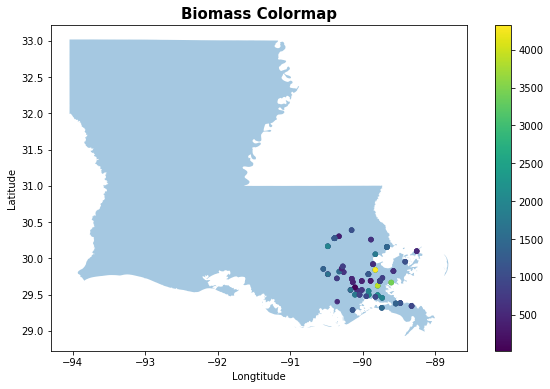

In [22]:
# Create axes for map object.
fig, ax = plt.subplots(figsize=(10, 6))
LA_plot(biomass, ax, alpha=1, label=label, legend=True,
            markersize=20, cmap="viridis", column="Total Plot Aboveground Live Biomass (g/m2)")
ax.set_title("Biomass Colormap", fontsize=15, fontweight="bold");

The above plot shows more data in the eastern region of the boot. There is a decent amount of data here, but it's still located in differnt regions than the datasets on hydrographic and soil data points. To tackle this problem, we can use interpolation. The plan is to interpolate each of the hydrographic and soil variables to the location of these actual biomass points

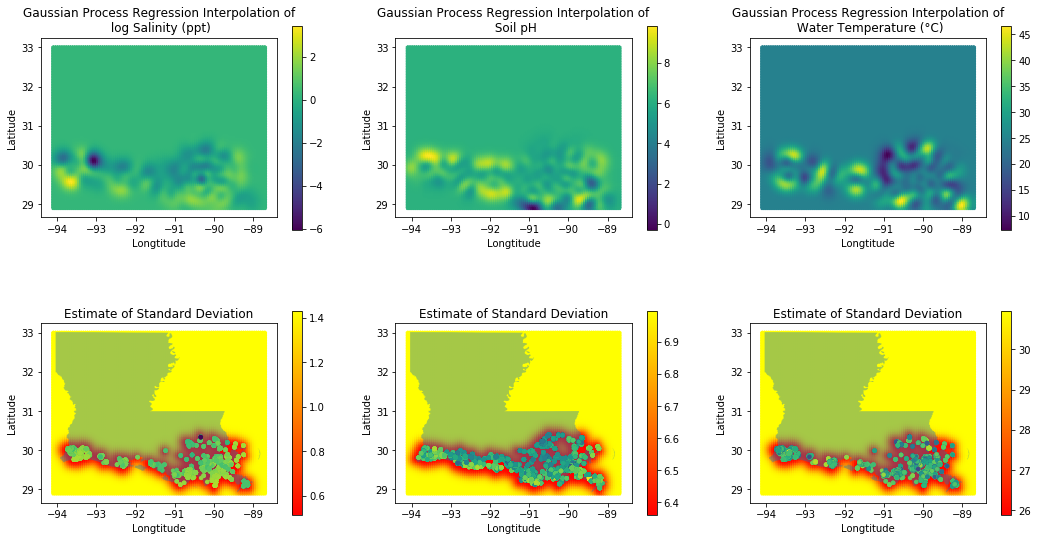

In [23]:
def gpr(X_test, X_train, y_train):
    """Use Gaussian Process Regression to interpolate a variable (Yname) across Lat/Long (Xname) points."""
    # Create kernel using radial basis function
    kernel = WhiteKernel(.05, "fixed") + RBF([.18, .18], "fixed")
    gp = GaussianProcessRegressor(kernel=kernel)
    # Create transformation to eliminate mean and scale.
    s = StandardScaler().fit(y_train)
    y_train = s.transform(y_train)
    # print(X_train, y_train, X_test)
    gp.fit(X_train, y_train)
    y, std = gp.predict(X_test, return_std=True)
    return X_test, s.inverse_transform(y), s.inverse_transform(std).reshape(-1, 1)

def get_domain(df, Xname, lin_density=10, xmins=None, xmaxs=None):
    """Create a domain for the interpolater."""
    if xmins is None and xmaxs is None:
        xmins = [df[xn].min() for xn in Xname]
        xmaxs = [df[xn].max() for xn in Xname]
    xs = [np.linspace(xmin, xmax, lin_density) for xmin, xmax in zip(xmins, xmaxs)]
    return np.concatenate(np.array(np.meshgrid(*xs)).T)
        
def make_interp_df(X, y, std, xname, yname):
    """Make a dataframe with new interpolated data"""
    df = pd.DataFrame(X, columns=xname)
    df[yname] = y
    df["std"] = std
    return df

def plot_GPR(xnames, yname, frame, axs):
    """Generate GPR interpolation plots for any given variable/dset combo."""
    # Get domain on the coast
    X_test = get_domain(frame, xnames, 100, xmins=[-94.1, 28.9], xmaxs=[-88.7, 33])
    # Run interpolation 
    X, y, std = gpr(X_test, frame[xnames].values, frame[yname].values.reshape(-1, 1)) 
    # Create table formatted for LA plot.
    interp_df = make_interp_df(X, y, std, xnames, yname)
    # Plot interpolation.
    LA_plot(interp_df, axs[0], alpha=1, legend=True,
            markersize=15, cmap="viridis", column=yname, marker="p")
    # Plot standard deviation.
    LA_plot(interp_df, axs[1], alpha=1, legend=True,
            markersize=15, cmap="autumn", column="std", marker="p")
    # Plot original measured data.
    LA_plot(frame, axs[1], alpha=1, label=label, legend=False,
                    markersize=50, cmap="viridis", column=yname, marker=".")
    axs[0].set_title(f"Gaussian Process Regression Interpolation of\n {yname}")
    axs[1].set_title("Estimate of Standard Deviation")

xnames = ["Longitude", "Latitude"]
# Feel free to play around with these settings, they will work for all our data so far,
# (as long as there are no NaN)

# Get smaller hydro frame that still has geographic diversity.
select = lambda grp: grp.loc[np.random.choice(grp.index, 10, True), :]
hydro_small = hydro.groupby('Station ID', as_index=False).apply(select)
salty_small = hydro_small[xnames + ["log Salinity (ppt)"]].dropna(how="any")
water_small = hydro_small[xnames + ["Water Temperature (°C)"]].dropna(how="any")

# These settings ~ 4 minutes
ynames = ["log Salinity (ppt)", "Soil pH", "Water Temperature (°C)"]
frames = [salty_small, soil[soil["Soil pH"].notna()], water_small]
# These settings ~ 10 seconds
# ynames = ["Total Plot Aboveground Live Biomass (g/m2)"]
# frames = [biomass]

# Create plotting objects
fig, axs = plt.subplots(2, len(ynames), figsize=(18, 9), squeeze=False)

# Loop through columns of figure
for col, yname, frame in zip(axs.T, ynames, frames):
    plot_GPR(xnames, yname, frame, col)

fig.subplots_adjust(hspace=.4)

The first row of plots above show the interpolation estimate at every point for three different variables. From this, we have gained the ability to evaluate any hydrographic variable at any locations (i.e. at our target variable locations). What's more, is we have an estimate of the standard deviation of the variable at any given location. This marks how certain or uncertain we are of a certain variable in a certain location. When we build our model, we will be able to weight certain variables that we are more certain about as being more impactful.

<a name="Stat"></a>
### Statistical Model

Let's do a time independent case study on a the sites that have biomass measurements and interpolate a variety of features nearby. The goal is to to find pvalues for hydrographic variables that are correlated with biomass density and growth. This will inform our regression model on which variables to focus on, and which variables we can likely ignore.

In [39]:
def stratified_sample(df, samples, by="Station ID"):
    """Get smaller data frame that still has geographic diversity."""
    select = lambda grp: grp.loc[np.random.choice(grp.index, samples, True), :]
    return df.groupby("Station ID", as_index=False).apply(select)

# Let's only use data from the same time period as our biomass data.
hydro_tslice = hydro[hydro.Datetime.map(lambda x: x.year in [2016, 2017])]

# Only interested in numerical features.
num_cols = list(hydro_tslice.select_dtypes(include=np.number).columns)
# Keep Station ID for
hydro_num = hydro[["Station ID"] + num_cols].copy()

# Drop some more features.
drops = ["Staff Gauge (ft)", "Station Depth (ft)", "Measurement Depth (ft)"]
# Define training data frame and sample
dftr = hydro_num.drop(drops, axis=1)

# Define features for consideration.
LL = ["Latitude", "Longitude"]
features = [c for c in dftr if c not in LL+["Station ID"]]
target = "Total Plot Aboveground Live Biomass (g/m2)"

# Store calculated values and associated biomass
hydro_bio = biomass[LL + [target]].copy()
# Store uncertainties
hydro_bio_std = hydro_bio.copy()
# Cap size of array so program will actually run, also avoid resampling too many times
samples = [6, 6, 6, 6, 3, 1, 1, 1, 6, 2, 2, 2, 2, 3, 3, 6]
# samples = [1] * len(features)

for feature, nsample in zip(features, samples):
    print(feature)
    # Interpolate each feature, and take random stratified subset of the data (for performance)
    df_notna = stratified_sample(dftr[[feature, "Station ID"] + LL].dropna(how="any"), nsample)
    print("diagonalizing matrix of size " + f"({len(df_notna.index)}, {len(df_notna.index)})")
    X_train = df_notna[LL].values
    y_train = df_notna[feature].values.reshape(-1, 1)
    X_test = hydro_bio[LL].values
    X, y, std = gpr(X_test, X_train, y_train)
    # Add predicted values to dset.
    hydro_bio[feature] = y
    hydro_bio[f"{feature}_std"] = std

cmatrix = hydro_bio[features + [target]].corr()

Water Temperature (°C)
diagonalizing matrix of size (6858, 6858)
Specific Conductance (uS/cm)
diagonalizing matrix of size (6480, 6480)
Salinity (ppt)
diagonalizing matrix of size (7014, 7014)
Dissolved Oxygen (mg/L)
diagonalizing matrix of size (588, 588)
pH
diagonalizing matrix of size (36, 36)
Soil Porewater Temperature (°C)
diagonalizing matrix of size (6032, 6032)
Soil Porewater Specific Conductance (uS/cm)
diagonalizing matrix of size (6006, 6006)
Soil Porewater Salinity (ppt)
diagonalizing matrix of size (6057, 6057)
Turbidity (FNU)
diagonalizing matrix of size (450, 450)
Nitrate+Nitrite as N (filtered; mg/L)
diagonalizing matrix of size (24, 24)
Ammonium as N (filtered; mg/L)
diagonalizing matrix of size (24, 24)
Orthophosphate as P (filtered; mg/L)
diagonalizing matrix of size (24, 24)
Silica (filtered; mg/L)
diagonalizing matrix of size (24, 24)
Secchi (ft)
diagonalizing matrix of size (96, 96)
Fecal Coliform (MPN/100ml)
diagonalizing matrix of size (99, 99)
log Salinity (ppt

Water Temperature (°C)                         0.046577
Specific Conductance (uS/cm)                   0.092705
Salinity (ppt)                                 0.052572
Dissolved Oxygen (mg/L)                       -0.265841
pH                                             0.188730
Soil Porewater Temperature (°C)                0.112796
Soil Porewater Specific Conductance (uS/cm)    0.149949
Soil Porewater Salinity (ppt)                  0.131060
Turbidity (FNU)                                0.022172
Nitrate+Nitrite as N (filtered; mg/L)          0.161613
Ammonium as N (filtered; mg/L)                -0.127053
Orthophosphate as P (filtered; mg/L)          -0.158313
Silica (filtered; mg/L)                        0.103301
Secchi (ft)                                   -0.136421
Fecal Coliform (MPN/100ml)                    -0.282362
log Salinity (ppt)                             0.114973
Total Plot Aboveground Live Biomass (g/m2)     1.000000
Name: Total Plot Aboveground Live Biomass (g/m2)

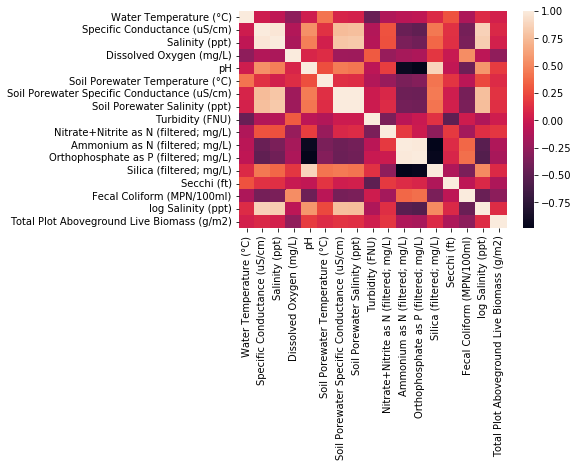

In [40]:
# Let's display these correlations
sns.heatmap(cmatrix)
display(cmatrix[target])

### Regression Model

One of the best ways of combatting land erosion from wind and water is to plant vegetation near the coast. Plant roots spread through the sand making it more resilient against erosion, and above-ground vegitation encourages natural dune formation. Newly planted material often takes an entire season to establish itself and its protective effects are cumulative but slow. Sometimes it is necessary to take more immediate action into protecting the coast, such as the use of sandbags, man made dunes, or sea walls. Sea walls can often be difficult to maintain, as with sandbags, and these methods typically prevent futher vegitative growth in the area. Even man-made sand dunes lack the continuous density gradient that natural sands have which encourages plant-root growth. For these reasons we would like to use hydrographic, vegitation, and accretion data in order to classify regions of the coast as best being protected by one of the above methods.

To do this we will identify the hydrographic conditions that afford vegetative growth, search for locations that have little vegetation but the opportunity to grow more, and determine if active planting will be a good solution for that area. Alternatively, if the hydrographic conditions are not condusive to plant growth, we may classify that region as being best protected by unnatural sand formations.

As a secondary part of our model, we would like to use accretion data see how the coast is evolving overtime. If we could calculate how quickly the coastline is receeding in certain areas, then we could determine an "urgency" metric and rule out certain regions of the coast from viably being protected with plants. We may try to obtain population location data to try to determine weights to how urgent erosion prevention is in certain places across the coast.

### Plan

1. Build statistical model to obtain p-values for hydrographic features that are highly correlated with vegetation on the Louisiana Coast.
2. Select those features below a significant p threshold, and use them in a classification model
3. Interpolate hydrographic features to the geography.
    - Possibly use Gaussian Process Regression in order to obtain confidence intervals to address missing data         issues.
    - Alternatively, we could restrict our analysis to a smaller region with lots of significant variable data.
4. Partition the regions into areas with and without vegetative growth, then classify in regions without growth whether or not plants could grow there based on hydrgraphic similarity to vegetative regions.
5. Recession Rate
6. Economic factors

<a name="Res"></a>
### Results